In [1]:
""" https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf
https://user.ceng.metu.edu.tr/~emre/resources/courses/AdvancedDL_Spring2017/DQN_Muhammed.pdf
https://www.youtube.com/watch?v=NP8pXZdU-5U&t=1s """
import matplotlib.pyplot as plt
import torch
import numpy as np
from copy import deepcopy
from tqdm import tqdm
from SpaceInvaders import *
from Agent import *
import collections
import random
from itertools import count

pygame 2.1.2 (SDL 2.0.18, Python 3.10.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


TRY:
- Longer training
- More layers in NN
- Bigger layers in NN
- Different loss

Using device:  cpu
Using device:  cpu
Epsilon projection for final eps = 0.0:


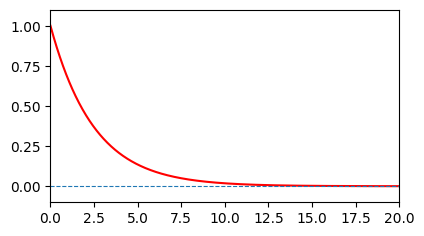

In [2]:
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.0
EPS_DECAY = 0.4
TARGET_UPDATE = 50
MY_SEED = 143
LR = 0.00005
MEMORY_SIZE = 1000000
NUM_EPISODES = 20
state_size = 150
nr_actions = 6

agent_007 = Agent(gamma=GAMMA,exploration_rate=EPS_START,lr=LR,
                  input_size=state_size, batch_size=BATCH_SIZE,
                  nr_actions=nr_actions, max_mem_size=MEMORY_SIZE,
                  nr_consecutive_frames=1, exploration_rate_min=EPS_END,
                  exploration_decay_rate=EPS_DECAY,seed=MY_SEED)

print(f"Epsilon projection for final eps = {EPS_END}:")
fig, ax = plt.subplots(1,1,figsize=(4.5,2.5))
eps = np.linspace(0.00001,NUM_EPISODES,1000)

#### Different epsilon decay strategies ####
#ys = 1.0 - EPS_DECAY * eps
#ys = agent_007.stretched_exponential_view(eps,NUM_EPISODES,EPS_START,EPS_END)
#ys = agent_007.linear_view(eps,EPS_START,EPS_DECAY)
ys = agent_007.exponential_decay(eps)
#ys = agent_007.oscillator(eps,EPS_START,EPS_END,NUM_EPISODES,A = 3.5,B=20)
#ys = agent_007.inverse_power(eps,EPS_DECAY,EPS_START,EPS_END)
#ys = agent_007.exponential_ski_hill(eps,EPS_DECAY,EPS_START,EPS_END)
eps, ys = eps[ys >= EPS_END], ys[ys >= EPS_END]
ax.plot(eps, ys,'r-')
ax.set_xlim(0,NUM_EPISODES)
ax.set_ylim(-0.1,1.1)
ax.hlines(EPS_END,0,NUM_EPISODES,lw=0.8,ls='--')
plt.show()

In [3]:

episode_durations = []
episode_rewards = []
episode_exploration_rates = []
episode_levels = []

t_total_counter = 0
with tqdm(range(NUM_EPISODES)) as pbar:
    for i_episode in pbar:
        # Initialize the environment and state
        game_env = SpaceInvadersApp(seed=MY_SEED + i_episode,  # Try both constant seed and varying seed for each episode
                                    display_gameplay=False)
        game_env.initialize_environment()

        current_game_score = 0
        current_game_duration = 0

        current_exploration_rate = 0
        current_steps_counter = 0
        game_over = False
        current_state = game_env.get_state()

        for t in count():
            # Select and perform an action according to greedy epsilon strategy
            action = agent_007.choose_action(current_state)

            # Perform action in game environment and observe reward and new state + termination flag.
            reward, game_over, new_observation = game_env.step(action)
            current_game_score += reward
            reward = torch.tensor([reward])

            # Observe new state
            last_state = current_state
            current_state = new_observation

            # Store the transition in memory
            # print(type(last_state), type(action),type(reward),type(current_state),type(game_over))
            agent_007.store_transition(state=last_state, action=action,
                                       reward=reward, new_state=current_state,
                                       done_flag=game_over)

            # Perform one step of the optimization (on the policy network)
            agent_007.learn(episode=i_episode)
            if game_over:
                break
            t_total_counter += 1
            current_game_duration += 1

            # Update the target network, copying all weights and biases in DQN from policy to target network
            if t % TARGET_UPDATE == 0:
                agent_007.align_networks()

        episode_rewards.append(current_game_score)
        episode_durations.append(current_game_duration)
        episode_exploration_rates.append(agent_007.exploration_rate)
        episode_levels.append(game_env.current_level)

        pbar.set_postfix({"Level reached": game_env.current_level})

100%|██████████| 20/20 [04:03<00:00, 12.17s/it, Level reached=2]


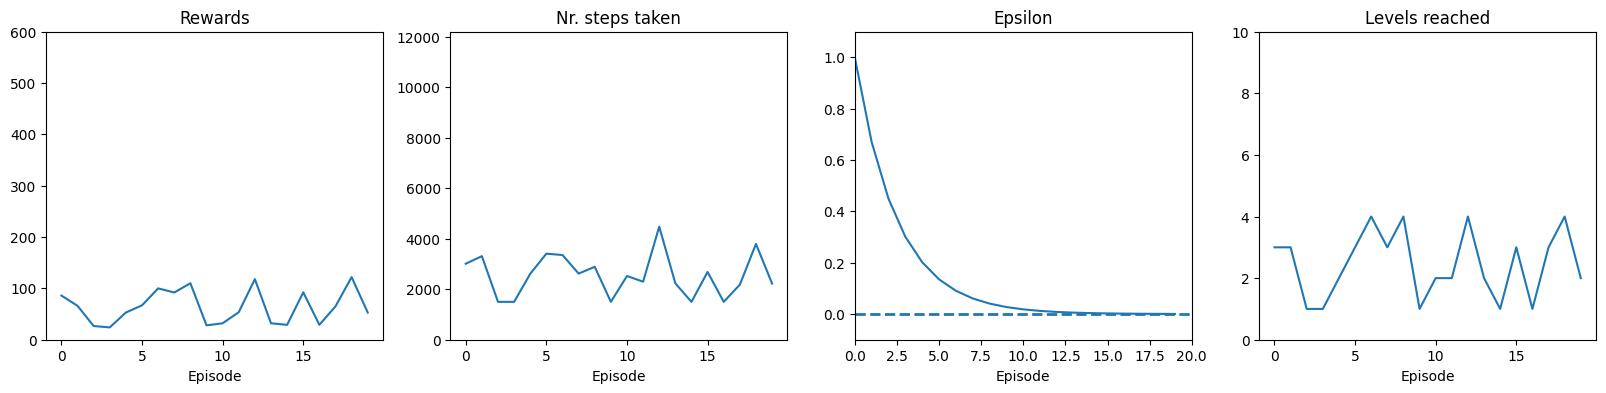

In [4]:

fig, ax = plt.subplots(1, 4, figsize=(20, 4))
ax[0].plot([i for i in range(len(episode_rewards))], episode_rewards)
ax[0].set_ylim(0,600)
ax[0].set_title("Rewards")
ax[0].set_xlabel("Episode")

ax[1].plot([i for i in range(len(episode_durations))], episode_durations)
ax[1].set_title("Nr. steps taken")
ax[1].set_ylim(0,12200)
ax[1].set_xlabel("Episode")

ax[2].plot([i for i in range(len(episode_exploration_rates))], episode_exploration_rates)
ax[2].set_title("Epsilon")
ax[2].set_ylim(-0.1,1.1)
ax[2].hlines(EPS_END,0,NUM_EPISODES,ls="--",lw=2)
ax[2].set_xlim(0,NUM_EPISODES)
ax[2].set_xlabel("Episode")

ax[3].plot([i for i in range(len(episode_levels))], episode_levels)
ax[3].set_ylim(0,10)
ax[3].set_title("Levels reached")
ax[3].set_xlabel("Episode")
plt.show()

In [5]:
avg_period = NUM_EPISODES//10
avg_episode_rewards, avg_episode_durations, avg_episode_exploration_rates = [], [], []
for period in range(0, len(episode_rewards) // avg_period):
    avg_episode_rewards.append(np.mean(episode_rewards[avg_period * period : avg_period * (period + 1)]))
    avg_episode_durations.append(np.mean(episode_durations[avg_period * period : avg_period * (period + 1)]))
    avg_episode_exploration_rates.append(np.mean(episode_exploration_rates[avg_period * period : avg_period * (period + 1)]))

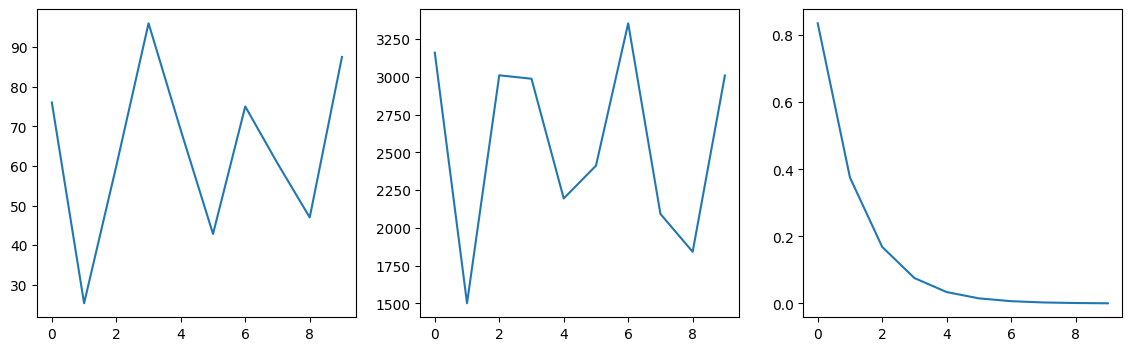

In [6]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot([ i for i in range(len(avg_episode_rewards))], avg_episode_rewards)
ax[1].plot([ i for i in range(len(avg_episode_durations))], avg_episode_durations)
ax[2].plot([ i for i in range(len(avg_episode_exploration_rates))], avg_episode_exploration_rates)
plt.show()

In [7]:
Play_game = False
if Play_game:
    game_env = SpaceInvadersApp(display_gameplay=True,seed=0,neural_net=agent_007.policy_network)
    game_env.on_execute()

